## Setup, Loading Data and CDFs

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
CWD = os.getcwd()
from reporting import *
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots", "results", "fit_categorization")
np.random.seed(0)

In [4]:
from sklearn.neighbors import NearestNeighbors

def knn_density(x, xs, k=50):
    """
    x  = sample array
    xs = points where density should be evaluated
    k  = number of neighbors
    """
    x = x.reshape(-1, 1)
    xs = xs.reshape(-1, 1)

    # Fit nearest neighbor structure
    nbrs = NearestNeighbors(n_neighbors=k).fit(x)

    # Distances to k-th neighbor
    dist, _ = nbrs.kneighbors(xs)
    dk = dist[:, -1]  # last column = k-th neighbor distance

    # k-NN density estimate
    n = len(x)
    f = k / (2 * n * dk)
    return f


Name the notebook:
blue_diagonal_wavelet_full_segmentAnything.ipynb


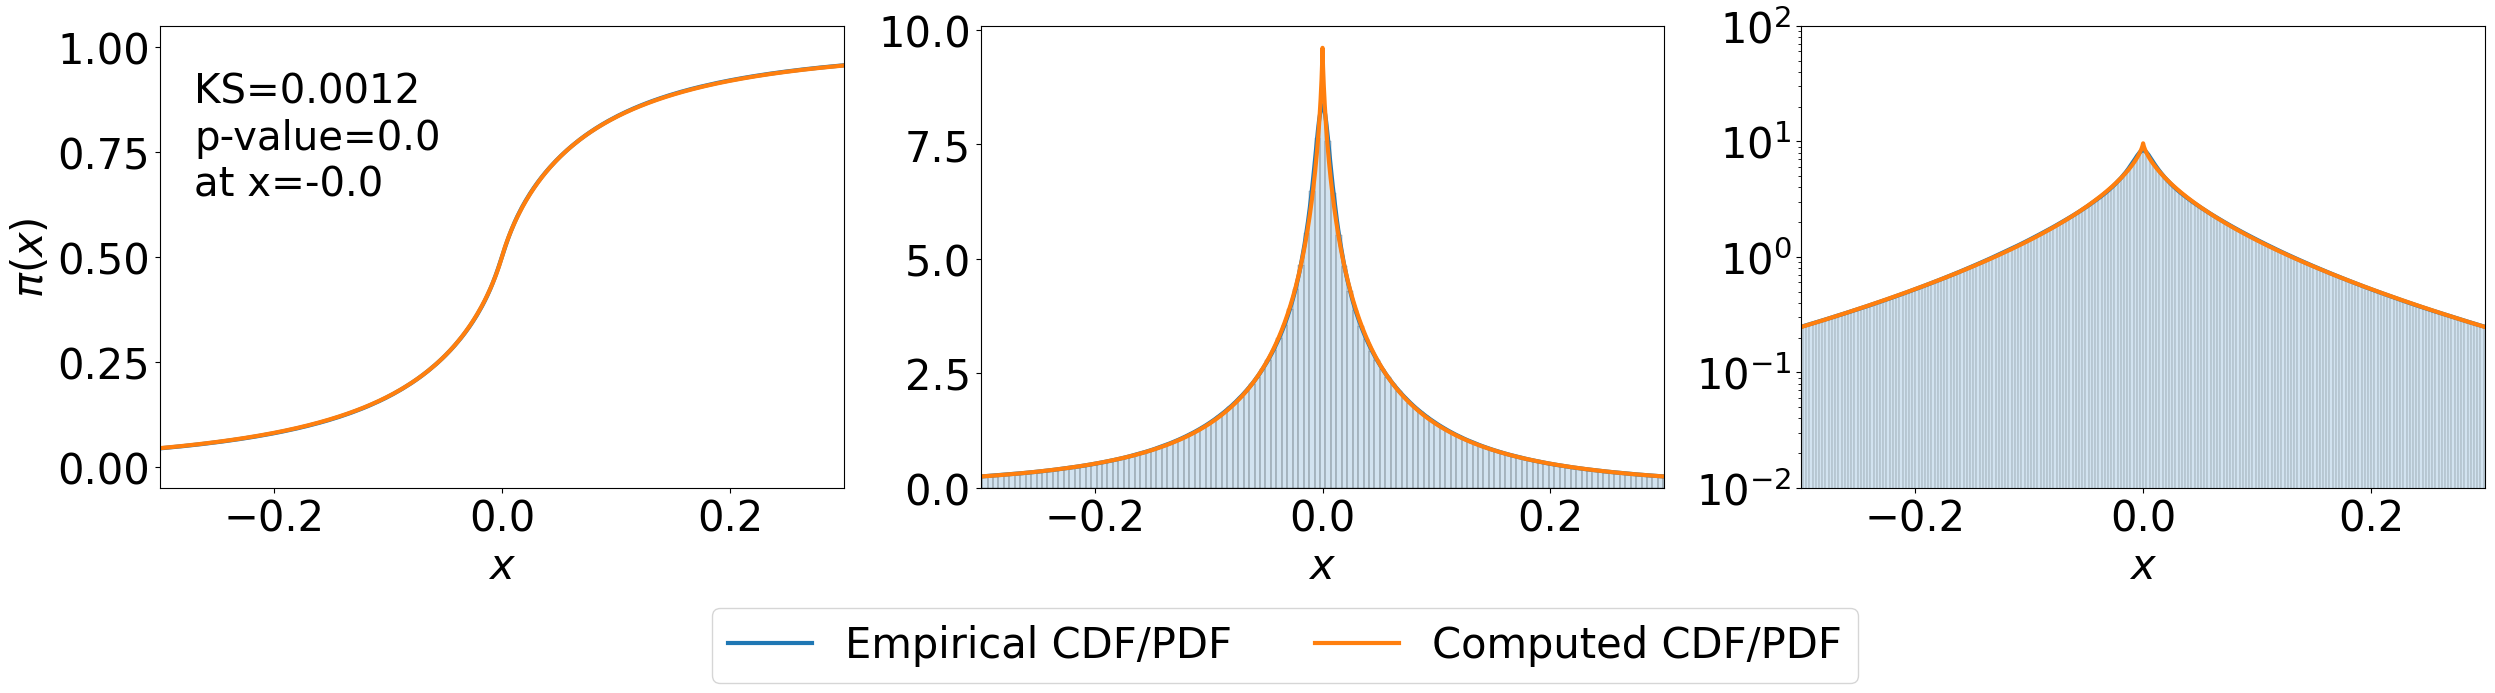

In [6]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'blue'

r1, eta1, scale1 = 0.29, -0.6, 2.792e-4
n_samples = 5000
group = 10


path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
sample = group_data_map[group]
sample_size = group_total_samples[group]

params1 = (r1, eta1, scale1)
log_scale = True


distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
        if distro == 'gengamma':
            if len(params) == 3:
                r, eta, scale = params
            else:
                r, eta = params
                scale = 1
            xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
            null_pdf = null_cdf.derivative()(xs_pdf)
        elif distro == 'gaussian' or distro == 'normal':
            null_cdf = stats.norm(scale=params).cdf
            xs_pdf = np.linspace(-30, 30, 10000)
            null_pdf = stats.norm(scale=params).pdf(xs_pdf)
        elif distro == 'laplace':
            null_cdf = stats.laplace(scale=params).cdf
            xs_pdf = np.linspace(-30, 30, 10000)
            null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
        return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)


if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    #print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)
    
        #paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        pvalue = stats.kstwo.sf(distance1, sample_size)
        location1 = round(float(location1), 2)
        ax1.text(
            0.05, 0.9, 
            f"KS={np.round(distance1, 4)} \np-value={np.round(pvalue, 2)}\nat x={location1} ", 
            transform=ax1.transAxes, 
            fontsize=fontsize -1, 
            verticalalignment='top', 
            horizontalalignment='left'
        )
        
        #print(location1)
        ax1.plot(xs, null_cdf1(xs),  linewidth=linewidth, label='Computed CDF/PDF')

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        #sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
            xs_knn = np.linspace(interval[0], interval[1], 15000)

            f_knn = knn_density(sample, xs_knn, k=2000)

            ax2.plot(xs_knn, f_knn, linewidth=linewidth, label='kNN density')

    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)


    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-3, top=0.1)

    if len(sample) > 0:
        #sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')
           
            xs_knn = np.linspace(interval[0], interval[1], 15000)

            f_knn = knn_density(sample, xs_knn, k=2000)

            ax3.plot(xs_knn, f_knn, linewidth=linewidth, label='kNN density')
    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    #handles, labels = ax1.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")


    ax3.set_ylim(bottom=10**-2, top=100)
    

    

    ax1.set_xlim((-0.3, 0.3))
    ax2.set_xlim((-0.3, 0.3))
    ax3.set_xlim((-0.3, 0.3))

    
    #plt.tight_layout()
ax1.set_xlabel(r"$x$", fontsize=fontsize)
ax2.set_xlabel(r"$x$", fontsize=fontsize)
ax3.set_xlabel(r"$x$", fontsize=fontsize)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.25), 
    ncol=2, 
    fontsize=fontsize
)